# Tutorial 1: Detecting anomalous cells from scRNA-seq human lung datasets
In this tutorial, we will show how to use M2ASDA for detecting anomalous cells. Here, we use two human scRNA-seq datasets: a healthy lung tissue (also 10xG-hHL) and a lung cancer (also 10xG-hLC-A). Detailed information about these datasets will be provided as follows.

## Loading packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

If you have pulled the project from GitHub and have not installed it as a package, you can import M2ASDA using a relative path.

In [2]:
import os

# Change the working path to the source codes automatically
notebook_path = os.path.abspath('')
project_root = os.path.abspath(os.path.join(notebook_path, '..', '..'))

src_path = os.path.join(project_root, 'src/')
os.chdir(src_path)

Then, m2asda and related packages can be loaded successfully. If you have installed M2ASDA as a package, you can skip the above step.

In [3]:
import m2asda

import scanpy as sc
import pandas as pd

## Reading scRNA-seq datasets

Here, we read two scRNA-seq datasets. The necessary input files should be formatted as `h5ad`, and include: expression matrix `.X`. Moreover, the reference dataset should include only normal cells, while the target dataset includes both normal and tumor cells. Additionally, in this tutorial, the meta data in `.obs` is mainly for evaluation, and is unnecessary for training.

In [4]:
# Normal dataset
ref = sc.read_h5ad('/volume3/kxu/scdata/Cancer/Process_A.h5ad')  # replace as your path
ref.obs.head(10)

,cell.type,cell.subtype,cell.newtype,batch,tissue_type,detail_cell.type
AAACCCAAGACATCCT-1,Epithelial,AT1,Epithelial,A,Normal,Epithelial_Normal
AAACCCACAAGTACCT-1,Immune,Macrophage,Immune (Myeloid),A,Normal,Immune_Normal
AAACCCACACGCTATA-1,Immune,T_CD8,Immune (Lymphoid),A,Normal,Immune_Normal
AAACCCACAGGTATGG-1,Immune,T_CD8,Immune (Lymphoid),A,Normal,Immune_Normal
AAACCCAGTACAACGG-1,Immune,Macrophage_proliferating,Immune (Myeloid),A,Normal,Immune_Normal
AAACCCAGTCCAGCGT-1,Immune,Macrophage,Immune (Myeloid),A,Normal,Immune_Normal
AAACCCATCATAGGCT-1,Epithelial,Ciliated,Epithelial,A,Normal,Epithelial_Normal
AAACGAACAAGACCTT-1,Immune,Macrophage,Immune (Myeloid),A,Normal,Immune_Normal
AAACGAACAGCGTGCT-1,Stromal,Lymphatic,Stromal,A,Normal,Stromal_Normal
AAACGAAGTCGGATTT-1,Immune,Macrophage,Immune (Myeloid),A,Normal,Immune_Normal


In [5]:
ref

AnnData object with n_obs × n_vars = 8104 × 3000
    obs: 'cell.type', 'cell.subtype', 'cell.newtype', 'batch', 'tissue_type', 'detail_cell.type'
    var: 'name'
    uns: 'cell.newtype_colors', 'cell.subtype_colors', 'cell.type_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
# Anomaly dataset
tgt = sc.read_h5ad('/volume3/kxu/scdata/Cancer/Process_B.h5ad')  # replace as your path
tgt.obs.head(10)

,tissue_type,cell.type,cell.subtype,detail_cell.type,cell.newtype
AAACCCAAGATAGGGA-1,Normal,Immune,B,Immune_Normal,Immune (Lymphoid)
AAACCCAAGTAGCATA-1,Tumor,Immune,T_conv,Immune_Tumor,Immune (Lymphoid)
AAACCCACAGTCAGAG-1,Tumor,Epithelial,Tumor,Epithelial_Tumor,Epithelial
AAACCCACAGTCTCTC-1,Tumor,Immune,Monocyte,Immune_Tumor,Immune (Myeloid)
AAACCCAGTTATAGAG-1,Normal,Immune,T_CD8,Immune_Normal,Immune (Lymphoid)
AAACCCAGTTCGGCCA-1,Normal,Immune,T_CD8,Immune_Normal,Immune (Lymphoid)
AAACCCATCCGGTAGC-1,Normal,Immune,NK,Immune_Normal,Immune (Lymphoid)
AAACCCATCCGTGGCA-1,Normal,Stromal,Fibro,Stromal_Normal,Stromal
AAACGAAAGTAAGCAT-1,Normal,Immune,NK,Immune_Normal,Immune (Lymphoid)
AAACGAACATGCTGCG-1,Normal,Immune,Mast,Immune_Normal,Immune (Myeloid)


In [7]:
tgt

AnnData object with n_obs × n_vars = 7721 × 3000
    obs: 'tissue_type', 'cell.type', 'cell.subtype', 'detail_cell.type', 'cell.newtype'
    var: 'name'
    uns: 'cell.newtype_colors', 'cell.subtype_colors', 'cell.type_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Training your model

M2ASDA supports automatic hyperparameter import. Here, the configuration obtained is a class. If you need to modify the hyperparameters, please modify the value of its attributes.

In [8]:
configs = m2asda.AnomalyConfigs()
configs = configs.__dict__
configs

{'n_epochs': 30,
 'batch_size': 256,
 'learning_rate': 0.0001,
 'n_critic': 2,
 'alpha': 30,
 'beta': 10,
 'gamma': 1,
 'lamb': 10,
 'GPU': 'cuda:0',
 'random_state': 2024,
 'n_genes': 3000}

In [9]:
model = m2asda.AnomalyModel(**configs)
model.train(ref)

Begin to train M2ASDA on the reference dataset...


Training Epochs: 100%|██████████| 30/30 [01:18<00:00,  2.62s/it, D_Loss=-1.4, G_Loss=7.21]  

Training process has been finished.


## Predicting and evaluation

When predicting anomalous cells, M2ASDA supports two modes: 1) outputting an anomaly score of [0,1], where a higher score indicates a higher anomaly probability; 2) outputting a judgment result of 0 or 1. And 1 indicates an anomalous cell, and 0 indicates a normal cell.

In [10]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
y_true = tgt.obs['tissue_type'] == 'Tumor'

In [11]:
score, label = model.predict(tgt, True)
df = pd.DataFrame({'score': score, 'label': label, 'true': y_true}, index=tgt.obs_names)
acc = accuracy_score(df['true'], df['label'])
f1 = f1_score(df['true'], df['label'])
roc_auc = roc_auc_score(df['true'], df['score'])
print(f'Accuracy: {acc}  F1-score: {f1}  ROC-AUC: {roc_auc}')

Begin to detect anomalies on the target dataset...
Anomalous spots have been detected.


Inference Epochs:  22%|██▏       | 22/100 [00:00<00:01, 64.24it/s]


GMM-based thresholder has converged.
Accuracy: 0.9029918404351768  F1-score: 0.9028660355336533  ROC-AUC: 0.9684167844581533


## Visualization

In [22]:
tgt.obs['score'] = score
tgt.obs['pred'] = label
tgt.obs['pred'] = tgt.obs['pred'].astype('category')

In [23]:
sc.pp.pca(tgt)
sc.pp.neighbors(tgt, use_rep='X_pca')
sc.tl.umap(tgt)

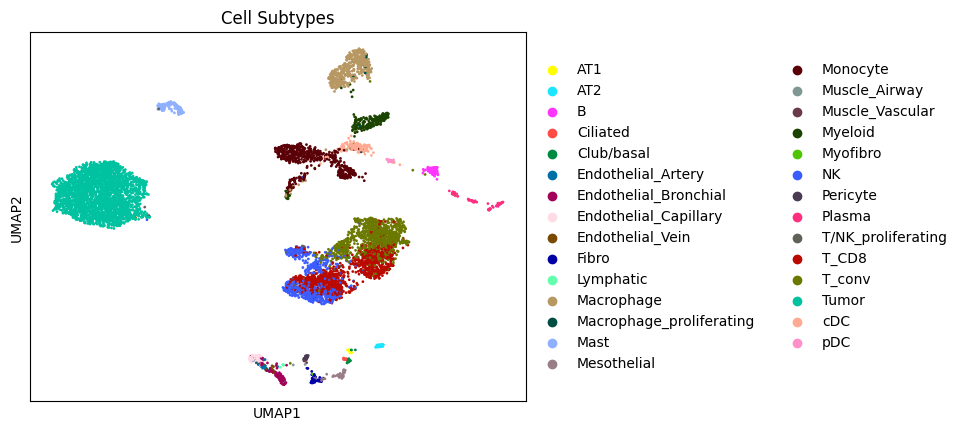

In [24]:
sc.pl.umap(tgt, color='cell.subtype', title='Cell Subtypes')

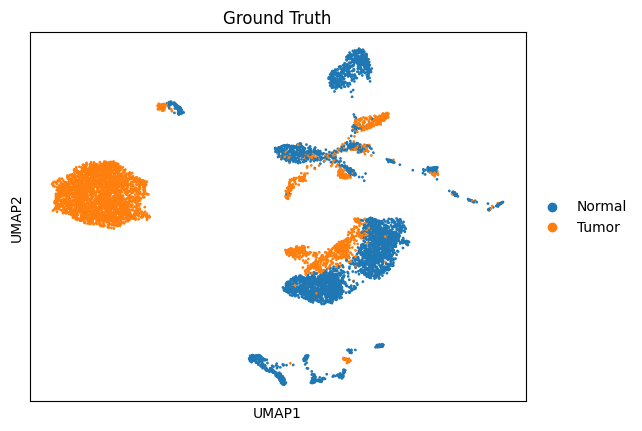

In [25]:
sc.pl.umap(tgt, color='tissue_type', title='Ground Truth')

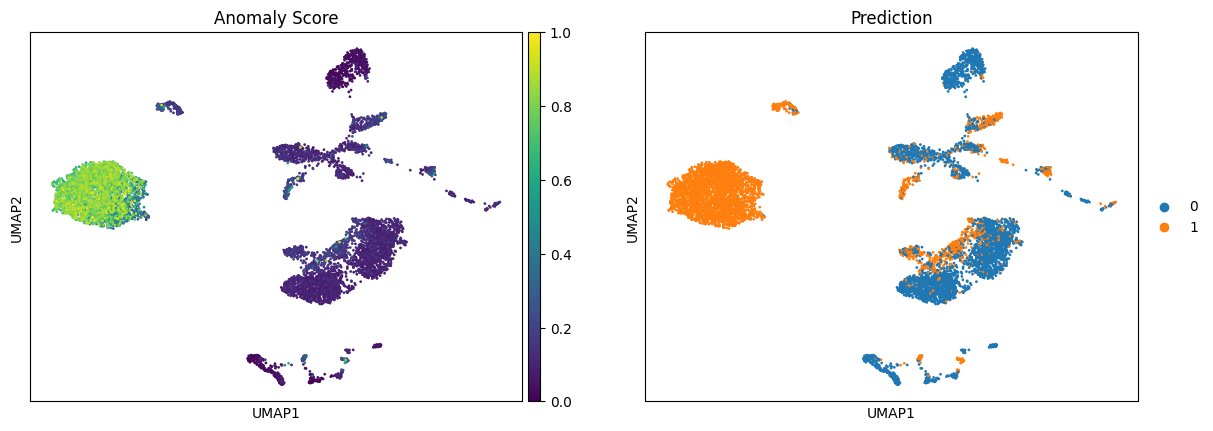

In [26]:
sc.pl.umap(tgt, color=['score', 'pred'], title = ['Anomaly Score', 'Prediction'])